In [1]:
# Procesado de datos
# ==============================================================================
import os
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

# Modelado 
# ==============================================================================
import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version Keras: {keras.__version__}")
print(f"{color}Using backend: {keras.backend.backend()}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        print(f"{color}Version tensorflow: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        print(f"{color}Version torch: {torch.__version__}")
    else:
        print(f"{color}Version torch: {jax.__version__}")


Version skforecast: 0.14.0
Version Keras: 3.6.0
Using backend: tensorflow
Version pandas: 2.2.2
Version numpy: 1.26.4
Version tensorflow: 2.18.0


In [2]:
# Descarga y procesado de datos
# ==============================================================================
resp = pd.read_excel("https://github.com/Wilsonsr/Series-de-Tiempo/raw/main/bases/Respiratorios.xlsx")
resp

c:\Users\wsand\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



,fecha,resp,pm10
0,2023-01-01,16,34.928212
1,2023-01-02,36,21.605515
2,2023-01-03,29,22.431935
3,2023-01-04,23,27.948804
4,2023-01-05,32,27.770948
...,...,...,...
457,2024-04-02,58,42.772210
458,2024-04-03,46,44.333686
459,2024-04-04,46,28.145419
460,2024-04-05,37,28.475029


In [3]:
resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   462 non-null    datetime64[ns]
 1   resp    462 non-null    int64         
 2   pm10    462 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.0 KB


In [4]:
resp.index=resp["fecha"]

In [5]:
# Asigna una frecuencia diaria
resp = resp.asfreq('D')

# Comprueba la frecuencia
print(f"Frecuencia: {resp.index.freq}")


Frecuencia: <Day>


In [6]:
# Comprobación de índice y frecuencia
# ==============================================================================
print(f"Tipo de índice: {resp.index.dtype}")
print(f"Frecuencia: {resp.index.freq}")

Tipo de índice: datetime64[ns]
Frecuencia: <Day>


In [7]:
# Split train-validation-test
# ==============================================================================
air_quality = resp.copy()
end_train = '2023-12-31'
end_validation = '2024-02-28'
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Fechas train      : {air_quality_train.index.min()} --- " 
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Fechas validation : {air_quality_val.index.min()} --- " 
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Fechas test       : {air_quality_test.index.min()} --- " 
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Fechas train      : 2023-01-01 00:00:00 --- 2023-12-31 00:00:00  (n=365)
Fechas validation : 2023-12-31 00:00:00 --- 2024-02-28 00:00:00  (n=60)
Fechas test       : 2024-02-28 00:00:00 --- 2024-04-06 00:00:00  (n=39)


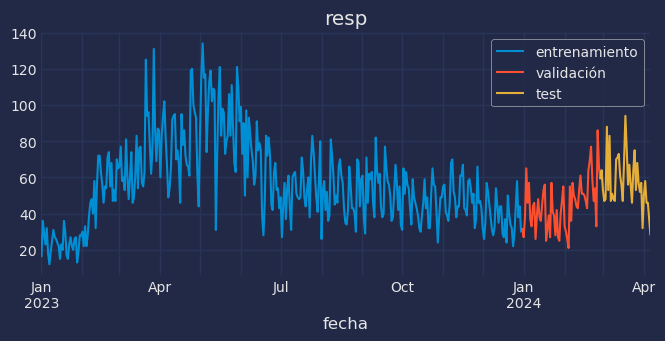

In [8]:
# Gráfico de la serie temporal del contaminante pm2.5
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
air_quality_train["resp"].plot(ax=ax, label="entrenamiento")
air_quality_val["resp"].plot(ax=ax, label="validación")
air_quality_test["resp"].plot(ax=ax, label="test")
ax.set_title("resp")
ax.legend();

In [9]:
# Creación del modelo
# ==============================================================================
series = ["resp"]  # Series temporales que se utilizarán para entrenar el modelo.
levels = ["resp"]  # Serie que se quiere predecir
lags = 32       # Valores pasados a utilizar en la predicción
steps = 1        # Pasos a futuro a predecir

# Selección de las series temporales utilizadas
data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Creación del forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,      # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)
forecaster

c:\Users\wsand\anaconda3\Lib\site-packages\skforecast\deep_learning\_forecaster_rnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

c:\Users\wsand\anaconda3\Lib\site-packages\skforecast\deep_learning\_forecaster_rnn.py:264: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



ForecasterRnn 
Regressor: <Functional name=functional, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['resp'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful

In [11]:
# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.1672 - val_loss: 0.0754
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270 - val_loss: 0.0450
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293 - val_loss: 0.0505
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262 - val_loss: 0.0422
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0227 - val_loss: 0.0429
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178 - val_loss: 0.0400
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0187 - val_loss: 0.0420
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - val_loss: 0.0414
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0196 - val_loss: 0.0423
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - val_loss: 0.0385


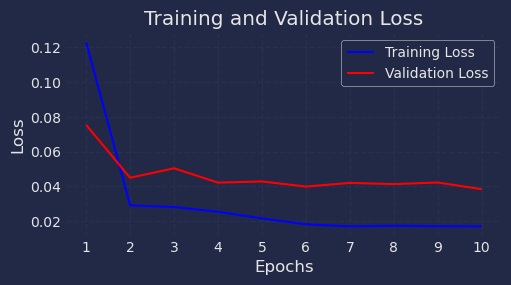

In [12]:
# Seguimiento del entrenamiento y overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)

In [13]:
# Predicción
# ==============================================================================
predictions = forecaster.predict()
predictions

c:\Users\wsand\anaconda3\Lib\site-packages\skforecast\deep_learning\_forecaster_rnn.py:727: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33846154 0.16923077 0.07692308 0.21538462 0.55384615 0.47692308
 0.36923077 0.26153846 0.15384615 0.10769231 0.18461538 0.50769231
 0.36923077 0.21538462 0.35384615 0.35384615 0.12307692 0.09230769
 0.24615385 0.04615385 0.44615385 0.29230769 0.2        0.16923077
 0.01538462 0.12307692 0.33846154 0.56923077 0.26153846 0.35384615
 0.13846154 0.16923077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,resp
2024-01-01,39.434738


In [14]:
# Backtesting con datos de test
# ==============================================================================
cv = TimeSeriesFold(
    steps=forecaster.max_step,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    refit=False,
)
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    levels=forecaster.levels,
    cv=cv,
    metric="mean_absolute_error",
    verbose=False,
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0177 - val_loss: 0.0385
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - val_loss: 0.0441
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - val_loss: 0.0393
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - val_loss: 0.0413
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151 - val_loss: 0.0412


  0%|          | 0/38 [00:00<?, ?it/s]

c:\Users\wsand\anaconda3\Lib\site-packages\skforecast\deep_learning\_forecaster_rnn.py:727: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.06153846 0.29230769 0.4        0.52307692 0.18461538 0.13846154
 0.07692308 0.         0.52307692 0.23076923 0.55384615 0.44615385
 0.41538462 0.35384615 0.33846154 0.49230769 0.61538462 0.46153846
 0.46153846 0.44615385 0.4        0.33846154 0.66153846 0.73846154
 0.86153846 0.58461538 0.4        0.50769231 0.18461538 1.
 0.69230769 0.58461538]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

c:\Users\wsand\anaconda3\Lib\site-packages\skforecast\deep_learning\_forecaster_rnn.py:727: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29230769 0.4        0.52307692 0.18461538 0.13846154 0.07692308
 0.         0.52307692 0.23076923 0.55384615 0.44615385 0.41538462
 0.3

In [15]:
# Predicciones de backtesting
# ==============================================================================
predictions

,resp
2024-02-29,57.527821
2024-03-01,58.780895
2024-03-02,56.791229
2024-03-03,54.693630
2024-03-04,53.610004
2024-03-05,61.424366
2024-03-06,57.295952
2024-03-07,62.961670
2024-03-08,57.661617
2024-03-09,56.931942


In [16]:
# Gráfico de las predicciones vs valores reales en el conjunto de test
# ==============================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['resp'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['resp'], name="predicciones", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicciones vs valores reales en el conjunto de test",
    xaxis_title="Date time",
    yaxis_title="O3",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="left",
        x=0
    )
)
fig.show()

In [17]:
# Métricas de backtesting
# ==============================================================================
metrics

,levels,mean_absolute_error
0,resp,11.168453


In [18]:
# Error en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["resp"])
print(f"Media de la serie: {np.mean(data['resp']):0.2f}")
print(f"Error (mae) relativo: {rel_mse:0.2f} %")

Media de la serie: 55.29
Error (mae) relativo: 20.20 %
